In [1]:
# Library imports
import numpy as np
import pickle
import matplotlib.pyplot as plt
import random

import tools
from train import generate_graph, train

In [2]:
# Fix random seed for reproducibility
np.random.seed(628496)
random.seed(628496)

# Stop on errors
np.seterr('raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
# Load the anonymous data
file_path = 'datasets\\real_data_graph.pkl'
with open(file_path, 'rb') as f:
    edges_by_day, last_day, raw_accounts = pickle.load(f)


In [4]:
# Count the number of generated edges to validate that the correct data is loaded
count_edges = sum(len(day) for day in edges_by_day.values())
print(f'There were {count_edges} edges generated.')

There were 295 edges generated.


In [5]:
# Remove three (4, 7) edges

# Find (4, 7) edges
target_edge_days = []
for day in sorted(list(edges_by_day.keys())):
    edges = edges_by_day[day]
    for edge in edges:
        if edge[0] == 4 and edge[1] == 7:
            target_edge_days.append((day, edge[0], edge[1], edge[2]))

count_removed_edges = 3

# Choose random edges
random_edges = random.sample(target_edge_days, count_removed_edges)
random_days = set(edge[0] for edge in random_edges)

# Remove the edges from those days
for day, i, j, value in random_edges:
    edges_by_day[day].remove((i, j, value))

print(f'{count_removed_edges} edges were removed. {sum(len(edges) for edges in edges_by_day.values())} edges remaining.')

3 edges were removed. 292 edges remaining.


In [6]:
# Create a graph object with the generated accounts
graph = generate_graph(
    raw_accounts=raw_accounts,
    edges_by_day=edges_by_day,
    last_day=last_day,
    node_dimension=256,
    graph_kwords={
        'causal_learning_rate': 0.001,
        'spontaneous_learning_rate': 10**(-6),
        'spontaneous_learning_rate': 10**(-6),
        'weight_regularisation_rate': 10**(-6)
    }
)

In [7]:
# Train on the tainted data
probabilities = train(
    graph, edges_by_day, last_day, iterations=200,
    plot_log_likelihood=False, use_tqdm=True,
    spontaneous_learning_startpoint=150
    )

100%|██████████| 200/200 [2:36:09<00:00, 46.85s/it]  


In [8]:
# Save the trained model and results
with open('saved_results//missing_edges_anonymised_results.pkl', 'wb') as f:
    pickle.dump((probabilities, graph), f)

In [9]:
# Find the probability that the number of a particular edge type on a particular
# day is lower than expected (suggesting edges have been removed/omitted)
all_probabilities = tools.return_probabilities_of_missing_edges(graph, edges_by_day, last_day)

100%|██████████| 35/35 [00:07<00:00,  4.63it/s]


In [10]:
print(f'There were {len(all_probabilities)} day-edge pairs (including those with count=0).')

There were 40260 day-edge pairs (including those with count=0).


In [11]:
# Sort the probabilities from most to least suspicious
all_probabilities.sort(key=lambda x: x[3], reverse=True)

In [15]:
# Print the most suspicious entries
for details in all_probabilities[:20]:
    print(details)

(245, 2, 3, 0.9469321173757579, 0, 2.9361833807290747, 1.0292434742965873e-06, 2.9361823514856003)
(246, 3, 9, 0.8805587903785064, 0, 2.124930998361982, 1e-06, 2.124929998361982)
(247, 3, 9, 0.8352156773157231, 0, 1.803117795374829, 1e-06, 1.803116795374829)
(250, 2, 7, 0.817956599599938, 0, 1.7035101565966955, 1e-06, 1.7035091565966956)
(251, 7, 3, 0.807003585438514, 0, 1.6450836676514402, 1e-06, 1.6450826676514403)
(250, 7, 3, 0.806258502795798, 0, 1.64123049710934, 1e-06, 1.6412294971093402)
(251, 2, 7, 0.8009612925239119, 0, 1.6142559632421576, 1e-06, 1.6142549632421577)
(249, 2, 7, 0.7957395253343078, 0, 1.5883592630040206, 1e-06, 1.5883582630040207)
(245, 3, 9, 0.7780919488489433, 0, 1.5054921669119925, 1e-06, 1.5054911669119926)
(252, 7, 3, 0.7723655391304384, 0, 1.4800141783953025, 1e-06, 1.4800131783953026)
(251, 4, 3, 0.7717693021745795, 0, 1.4773983290175905, 1.0001406952311592e-06, 1.4773973288768953)
(249, 7, 3, 0.7691348640358996, 0, 1.4659215659489224, 1e-06, 1.465920565

In [17]:
# Find the locations of the added edges and the genuine edges
removed_rank = []
notremoved_rank = []
printed_genuine = 0
for i, edge in enumerate(all_probabilities):
    if edge[0] in random_days and edge[1] == 4 and edge[2] == 7:
        print(f'(Missing) Item {i+1} of {len(all_probabilities)}:', edge)
        removed_rank.append(i)
    elif edge[1] == 4 and edge[2] == 7:
        if printed_genuine < 20:
            print(f'(Genuine) Item {i+1} of {len(all_probabilities)}:', edge)
            printed_genuine += 1
        notremoved_rank.append(i)

(Genuine) Item 33 of 40260: (251, 4, 7, 0.6934170748846595, 0, 1.1822670051737014, 1e-06, 1.1822660051737015)
(Genuine) Item 34 of 40260: (252, 4, 7, 0.6934081527999236, 0, 1.1822379038957642, 1e-06, 1.1822369038957643)
(Genuine) Item 55 of 40260: (253, 4, 7, 0.6577828688273251, 0, 1.0723098569048737, 1e-06, 1.0723088569048738)
(Genuine) Item 58 of 40260: (250, 4, 7, 0.6560841844671197, 0, 1.0673583738462629, 1e-06, 1.067357373846263)
(Genuine) Item 132 of 40260: (254, 4, 7, 0.5878182419399314, 0, 0.88629086657525, 1e-06, 0.88628986657525)
(Genuine) Item 140 of 40260: (249, 4, 7, 0.5781952600949779, 0, 0.8632127736724313, 1e-06, 0.8632117736724313)
(Genuine) Item 315 of 40260: (255, 4, 7, 0.4892465999574891, 0, 0.6718683883461893, 1e-06, 0.6718673883461893)
(Genuine) Item 400 of 40260: (248, 4, 7, 0.4596194804666207, 0, 0.6154817217816358, 1e-06, 0.6154807217816358)
(Genuine) Item 645 of 40260: (256, 4, 7, 0.37587059325337124, 0, 0.4713975495067328, 1e-06, 0.4713965495067328)
(Genuine)

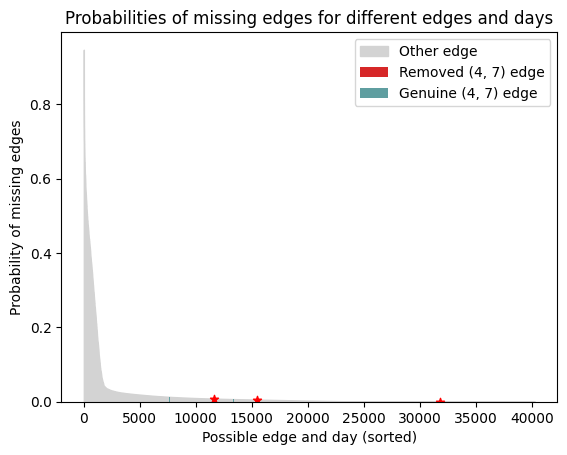

In [13]:
# Plot all the probabilities, highlighting which ones had edges removed and
# which ones related to the same edge type but were unamended
plt.fill_between(
    np.arange(len(all_probabilities)),
    np.zeros(len(all_probabilities)),
    np.array([edge[3] for edge in all_probabilities]),
    color='#d3d3d3',
    label='Other edge'
)
plt.bar(
    removed_rank,
    [all_probabilities[i][3] for i in removed_rank],
    width=1.0,
    color='#d62728',
    label='Removed (4, 7) edge'
)
plt.bar(
    notremoved_rank,
    [all_probabilities[i][3] for i in notremoved_rank],
    width=1.0,
    color='#5f9ea0',
    label='Genuine (4, 7) edge'
)
plt.scatter(
    removed_rank,
    [all_probabilities[i][3] for i in removed_rank],
    marker='*', c='red'
)

plt.legend(loc='upper right')

plt.xlabel('Possible edge and day (sorted)')
plt.ylabel('Probability of missing edges')
plt.title('Probabilities of missing edges for different edges and days')

plt.show()

In [14]:
print(f'Average removed rank: {np.mean([i+1 for i in removed_rank])}')
print(f'Genuine average rank: {np.mean([i+1 for i in notremoved_rank])}')

Average removed rank: 19634.666666666668
Genuine average rank: 20442.14876033058
